In [1]:
import numpy as np
import readdy
import matplotlib.pyplot as plt
import os
from collections import defaultdict
from collections import Counter
import ast
import h5py
from IPython.display import display, HTML
import io, contextlib, html



###############################################################################
# SIMULATION PARAMETERS (Most users adjust values here to customize behavior)
###############################################################################
CHECKPOINT_FILE = 'checkpoints_confocal_HR_image_single_cell_15/checkpoint_10000.h5'  # Load if continuing from a previous run
OUTPUT_FILE = 'mito_confocal_HR_image_single_cell_15.h5'                  # Where we save the confocal_HR_image_single_cell_15 simulation trajectory
COUNT_LOG_FILE = 'mito_confocal_HR_image_single_cell_15_reaction_counts.log'
FISSION_POSITION_LOG_FILE = 'mito_confocal_HR_image_single_cell_15_fission_position.log'
FUSION_POSITION_LOG_FILE = 'mito_confocal_HR_image_single_cell_15_fusion_position.log'
PARTICLE_POSITION_CSV_FILE = 'mito_confocal_HR_image_single_cell_15_particle_position.csv'
PDB_FILE = 'mito_confocal_HR_image_single_cell_15_pdb_files'
PSF_FILE = 'mito_confocal_HR_image_single_cell_15_psf_files'


BOX_SIZE = [2000, 2000, 0.01]  # [X, Y, Z] dimensions of the simulation box
ORIGIN = [ -BOX_SIZE[0]/2, -BOX_SIZE[1]/2, -BOX_SIZE[2]/2 ]  
# ^ Typically set so the box is centered around the origin

FORCE_CONSTANT_BOX = 100.0    # Strength of the box potential
DIFFUSION_CONSTANT = 0.02   # Particle diffusion constant

FORCE_CONSTANT_REPULSION = 10.0  # Strength of harmonic repulsion
INTERACTION_DISTANCE = 10.0       # Typical pairwise rest distance

FORCE_CONSTANT_BOND = 100.0      # Strength of bonds between topology nodes
LENGTH_BOND = 10                # Rest length for each bond (usually matches INTERACTION_DISTANCE)

FORCE_CONSTANT_ANGLE = 10.0
TWO_DEGREE_ANGLE = np.pi         # 180 degrees
THREE_DEGREE_ANGLE = np.pi/3     # 60 degrees

RADIUS_REACTION_1 = 15            # Radius for spatial fusion
RADIUS_REACTION_2 = 20            # Radius for spatial fusion
FUSION_RATE_1 = 0.05               # Rate for spatial fusion
FUSION_RATE_2 = 0.1               # Rate for spatial fusion
FISSION_BASE_RATE = 1        # Base factor in the fission rate function
DETECTION_RATE = 4              # Rate at which we detect potential "fusion_detect" reactions

N_THREADS = 16      # Number of CPU threads for ReaDDy's kernel
TIMESTEP = 0.1      # Integrator step size
N_STEPS = 310      # Total simulation steps
STRIDE = 10         # How often we record data (topologies, trajectory frames)

# Global counters to track the number of fission/fusion events
FISSION_COUNTS = 0
FUSION_COUNTS = 0

# Open log files for tracking positions of fission/fusion events
fission_position_log_file = open(FISSION_POSITION_LOG_FILE, 'w')
fusion_position_log_file = open(FUSION_POSITION_LOG_FILE, 'w')

In [2]:
###############################################################################
# READDY SYSTEM SETUP
###############################################################################
system = readdy.ReactionDiffusionSystem(box_size=BOX_SIZE)

# 1) Define topology types and species
system.topologies.add_type("mitochondria")
system.add_topology_species("mito_node_1", DIFFUSION_CONSTANT)
system.add_topology_species("mito_node_2", DIFFUSION_CONSTANT)
system.add_topology_species("mito_node_3", DIFFUSION_CONSTANT)

# 2) Add box potentials to confine each species
for ptype in ["mito_node_1", "mito_node_2", "mito_node_3"]:
    system.potentials.add_box(
        particle_type=ptype,
        force_constant=FORCE_CONSTANT_BOX,
        origin=ORIGIN,
        extent=BOX_SIZE
    )

# 3) Pairwise harmonic repulsions among all mito_node types
for (a, b) in [
    ("mito_node_1", "mito_node_1"),
    ("mito_node_1", "mito_node_2"),
    ("mito_node_1", "mito_node_3"),
    ("mito_node_2", "mito_node_2"),
    ("mito_node_2", "mito_node_3"),
    ("mito_node_3", "mito_node_3")
]:
    system.potentials.add_harmonic_repulsion(
        a, b,
        force_constant=FORCE_CONSTANT_REPULSION,
        interaction_distance=INTERACTION_DISTANCE
    )

# 4) Harmonic bonds for each pairing in the topology
for a in ["mito_node_1", "mito_node_2", "mito_node_3"]:
    for b in ["mito_node_1", "mito_node_2", "mito_node_3"]:
        system.topologies.configure_harmonic_bond(
            a, b,
            force_constant=FORCE_CONSTANT_BOND,
            length=INTERACTION_DISTANCE
        )
        
# 5) Harmonic angles to shape the topology
system.topologies.configure_harmonic_angle(
    "mito_node_1", "mito_node_2", "mito_node_2",
    force_constant=FORCE_CONSTANT_ANGLE,
    equilibrium_angle=TWO_DEGREE_ANGLE
)
system.topologies.configure_harmonic_angle(
    "mito_node_2", "mito_node_2", "mito_node_2",
    force_constant=FORCE_CONSTANT_ANGLE,
    equilibrium_angle=TWO_DEGREE_ANGLE
)
system.topologies.configure_harmonic_angle(
    "mito_node_1", "mito_node_3", "mito_node_2",
    force_constant=FORCE_CONSTANT_ANGLE,
    equilibrium_angle=THREE_DEGREE_ANGLE
)
system.topologies.configure_harmonic_angle(
    "mito_node_2", "mito_node_3", "mito_node_2",
    force_constant=FORCE_CONSTANT_ANGLE,
    equilibrium_angle=THREE_DEGREE_ANGLE
)
system.topologies.configure_harmonic_angle(
    "mito_node_3", "mito_node_3", "mito_node_3",
    force_constant=FORCE_CONSTANT_ANGLE,
    equilibrium_angle=THREE_DEGREE_ANGLE
)


In [3]:
###############################################################################
# STRUCTURAL REACTION (FISSION)
###############################################################################
def dissociation_rate_function(topology):
    """
    Fission rate is scaled by how many edges exist in the topology. 
    We only consider internal edges for removal.
    """
    edges = topology.get_graph().get_edges()
    if len(edges) <= 1:
        return 0.0

    counts = defaultdict(int)
    for e in edges:
        pix1 = e[0].get().particle_index
        pix2 = e[1].get().particle_index
        counts[pix1] += 1
        counts[pix2] += 1

    # Endpoints have exactly 1 edge
    endpoints = [pix for pix, c in counts.items() if c == 1]
    non_endpoint_edges = [
        e for e in edges
        if (e[0].get().particle_index not in endpoints
            and e[1].get().particle_index not in endpoints)
    ]

    if not non_endpoint_edges:
        return 0.0
    else:
        return FISSION_BASE_RATE * float(len(edges))


def dissociation_reaction_function(topology):
    """
    Selects an 'internal edge' to remove, updates particle types accordingly 
    (3->2, 2->1), and logs the event. This corresponds to 'fission.'
    
    Modification: Neighbors of endpoints (degree-1 vertices) are also treated as endpoints.
    """
    global FISSION_COUNTS
    recipe = readdy.StructuralReactionRecipe(topology)
    edges = topology.get_graph().get_edges()
    vertices = topology.get_graph().get_vertices()

    if len(edges) > 1:
        # 1) Count how many connections (edges) each particle_index has.
        counts = defaultdict(int)
        for e in edges:
            pix1 = e[0].get().particle_index
            pix2 = e[1].get().particle_index
            counts[pix1] += 1
            counts[pix2] += 1

        # 2) Identify 'true' endpoints (those whose degree == 1).
        endpoints = [pix for pix, c in counts.items() if c == 1]

        # 3) Collect neighbors of those endpoints so we can exclude them as well.
        neighbors_of_endpoints = set()
        for e in edges:
            pix1 = e[0].get().particle_index
            pix2 = e[1].get().particle_index
            # If an edge connects to an endpoint, both ends are considered "endpoint or neighbor."
            if pix1 in endpoints or pix2 in endpoints:
                neighbors_of_endpoints.add(pix1)
                neighbors_of_endpoints.add(pix2)

        # 4) Combine endpoints with their neighbors.
        endpoints_with_neighbors = set(endpoints).union(neighbors_of_endpoints)

        # 5) Only keep edges that do not touch endpoints or their neighbors.
        non_endpoint_edges = []
        for e in edges:
            pix1 = e[0].get().particle_index
            pix2 = e[1].get().particle_index
            if pix1 not in endpoints_with_neighbors and pix2 not in endpoints_with_neighbors:
                non_endpoint_edges.append(e)

        # 6) If we have edges that are truly "internal", pick one to remove.
        if non_endpoint_edges:
            edge_index = np.random.randint(0, len(non_endpoint_edges))
            removed_edge = non_endpoint_edges[edge_index]
            recipe.remove_edge(removed_edge[0], removed_edge[1])

            # Identify the vertices / particle indices
            pix1 = removed_edge[0].get().particle_index
            pix2 = removed_edge[1].get().particle_index
            vix1 = [i for i, v in enumerate(vertices) if v.particle_index == pix1][0]
            vix2 = [i for i, v in enumerate(vertices) if v.particle_index == pix2][0]

            current_type1 = topology.particle_type_of_vertex(vertices[vix1])
            current_type2 = topology.particle_type_of_vertex(vertices[vix2])

            # Log fission event
            FISSION_COUNTS += 1
            current_position1 = topology.position_of_vertex(vertices[vix1])
            current_position2 = topology.position_of_vertex(vertices[vix2])
            fission_position_log_file.write('fission: ' + str(FISSION_COUNTS) + '\n')
            fission_position_log_file.write(str(current_position1) + '\n')
            fission_position_log_file.write(str(current_position2) + '\n')

            # Decrease type states after losing a connection
            if current_type1 == "mito_node_2":
                recipe.change_particle_type(vix1, "mito_node_1")
            elif current_type1 == "mito_node_3":
                recipe.change_particle_type(vix1, "mito_node_2")

            if current_type2 == "mito_node_2":
                recipe.change_particle_type(vix2, "mito_node_1")
            elif current_type2 == "mito_node_3":
                recipe.change_particle_type(vix2, "mito_node_2")
        else:
            print("No internal edges to remove.")
    else:
        print("This should not have happened")
    return recipe

# Register the fission structural reaction
system.topologies.add_structural_reaction(
    "fission", 
    "mitochondria",
    dissociation_reaction_function,
    dissociation_rate_function
)

In [4]:
###############################################################################
# STRUCTURAL REACTION (FUSION DETECTION)
###############################################################################
def detection_rate_function(topology):
    """
    Returns a constant rate (DETECTION_RATE) at which we check the topology
    for 'fusion_detect_function' triggers.
    """
    edges = topology.get_graph().get_edges()
    return DETECTION_RATE


def fusion_detect_function(topology):
    """
    Custom structural reaction function that scans the topology graph 
    and changes particle types upon detecting specific fission/fusion criteria.
    """
    global FUSION_COUNTS
    recipe = readdy.StructuralReactionRecipe(topology)
    graph = topology.get_graph()
    vertices = graph.get_vertices()

    processed_particles = set()

    for vertex in vertices:
        particle_index = vertex.particle_index
        if particle_index in processed_particles:
            continue

        current_type = topology.particle_type_of_vertex(vertex)
        neighbors = list(vertex.neighbors())
        num_connections = len(neighbors)

        changes = []         # (vertex_to_change, new_type)
        fusions_to_log = []  # store (pos1, pos2) to log if fusion occurs

        # Case 1: Two mito_node_1s, each with 2 connections -> both become mito_node_2
        if current_type == "mito_node_1" and num_connections == 2:
            for neighbor in neighbors:
                neighbor_index = neighbor.particle_index
                if neighbor_index in processed_particles:
                    continue

                neighbor_type = topology.particle_type_of_vertex(neighbor)
                neighbor_connections = len(list(neighbor.neighbors()))

                if neighbor_type == "mito_node_1" and neighbor_connections == 2:
                    changes.append((vertex, "mito_node_2"))
                    changes.append((neighbor, "mito_node_2"))

                    processed_particles.add(particle_index)
                    processed_particles.add(neighbor_index)

                    FUSION_COUNTS += 1
                    pos_v = topology.position_of_vertex(vertex)
                    pos_n = topology.position_of_vertex(neighbor)
                    fusions_to_log.append((pos_v, pos_n))

        # Case 2: One mito_node_2 (3 connections) + One mito_node_1 (2 connections) 
        #         -> (mito_node_3, mito_node_2)
        elif current_type == "mito_node_2" and num_connections == 3:
            for neighbor in neighbors:
                neighbor_index = neighbor.particle_index
                if neighbor_index in processed_particles:
                    continue

                neighbor_type = topology.particle_type_of_vertex(neighbor)
                neighbor_connections = len(list(neighbor.neighbors()))

                if neighbor_type == "mito_node_1" and neighbor_connections == 2:
                    changes.append((vertex, "mito_node_3"))
                    changes.append((neighbor, "mito_node_2"))

                    processed_particles.add(particle_index)
                    processed_particles.add(neighbor_index)

                    FUSION_COUNTS += 1
                    pos_v = topology.position_of_vertex(vertex)
                    pos_n = topology.position_of_vertex(neighbor)
                    fusions_to_log.append((pos_v, pos_n))

        # Apply the changes collected
        for vertex_to_change, new_type in changes:
            recipe.change_particle_type(vertex_to_change, new_type)

        # Log new fusion events
        for (pos_v, pos_n) in fusions_to_log:
            fusion_position_log_file.write(f"fusion {FUSION_COUNTS}\n")
            fusion_position_log_file.write(str(pos_v) + '\n')
            fusion_position_log_file.write(str(pos_n) + '\n')

    return recipe

# Register the fusion structural reaction
system.topologies.add_structural_reaction(
    "fusion_detect",
    "mitochondria",
    fusion_detect_function,
    detection_rate_function
)

In [5]:
###############################################################################
# SPATIAL REACTIONS (FUSION)
# Defines how separate topologies can fuse if certain particle types come 
# within RADIUS_REACTION distance.
###############################################################################
system.topologies.add_spatial_reaction(
    "fusion_1: mitochondria(mito_node_1) + mitochondria(mito_node_1) -> mitochondria(mito_node_1--mito_node_1)",
    rate=FUSION_RATE_1, 
    radius=RADIUS_REACTION_1
)

system.topologies.add_spatial_reaction(
    "fusion_2: mitochondria(mito_node_1) + mitochondria(mito_node_2) -> mitochondria(mito_node_1--mito_node_2)",
    rate=FUSION_RATE_2, 
    radius=RADIUS_REACTION_2
)

In [6]:
##############################################################################
# SIMULATION SETUP
###############################################################################
simulation = system.simulation(kernel="CPU")
simulation.kernel_configuration.n_threads = N_THREADS

# Load from checkpoint if it exists (continuation of a previous run)
if os.path.exists(CHECKPOINT_FILE):
    simulation.load_particles_from_checkpoint(CHECKPOINT_FILE)

# Configure logging for reaction counts
counts_log_file = open(COUNT_LOG_FILE, 'w')
def log_reaction_counts(counts):
    counts_log_file.write(str(counts) + '\n')

simulation.observe.reaction_counts(stride=1, callback=log_reaction_counts, save=False)

# Output, integration, and reaction handler settings
simulation.output_file = OUTPUT_FILE
simulation.integrator = "EulerBDIntegrator"
simulation.reaction_handler = "Gillespie"

# Observe topologies and record the trajectory at specified stride
simulation.observe.topologies(stride=STRIDE)
simulation.observe.particles(stride= STRIDE)
simulation.record_trajectory(stride=STRIDE)

# Print progress to console every 10 steps
simulation.progress_output_stride = 10
simulation.show_progress = True


###############################################################################
# RUN SIMULATION
###############################################################################
# Overwrite output file if it already exists
if os.path.exists(simulation.output_file):
    os.remove(simulation.output_file)

output_buffer = io.StringIO()
with contextlib.redirect_stdout(output_buffer):
    simulation.run(N_STEPS, TIMESTEP)

# Close log files
counts_log_file.close()
fission_position_log_file.close()
fusion_position_log_file.close()


###############################################################################
# POST-PROCESSING: Convert the trajectory to XYZ for external visualization
###############################################################################
trajectory = readdy.Trajectory(OUTPUT_FILE)
trajectory.convert_to_xyz()

full_output = html.escape(output_buffer.getvalue())           # HTML‑safe
display(
    HTML(
        f'''
        <div style="
            max-height: 350px;
            overflow-y: auto;
            border: 1px solid #aaa;
            padding: 6px;
            font-family: monospace;
            white-space: pre-wrap;">
            {full_output}
        </div>
        '''
    )
)

100%|██████████| 31/31 [00:00<00:00, 49.63it/s]


[2025-07-14 15:33:26] [info] Simulation completed
[2025-07-14 15:33:26] [warning] type mito_node_3 had explicitly no specified radius, using 1.0
[2025-07-14 15:33:26] [warning] type mito_node_2 had explicitly no specified radius, using 1.0
[2025-07-14 15:33:26] [warning] type mito_node_1 had explicitly no specified radius, using 1.0


In [7]:
import h5py

def print_hdf5_structure(file_name):
    with h5py.File(file_name, 'r') as file:
        def print_group(name, obj):
            print(name)
        file.visititems(print_group)

# Replace 'your_trajectory_file.h5' with the path to your HDF5 file
print_hdf5_structure(OUTPUT_FILE)


readdy
readdy/config
readdy/config/general
readdy/config/particle_types
readdy/config/serialization_version
readdy/config/spatial_topology_reactions
readdy/config/structural_topology_reactions
readdy/config/topology_types
readdy/observables
readdy/observables/particles
readdy/observables/particles/ids
readdy/observables/particles/positions
readdy/observables/particles/time
readdy/observables/particles/types
readdy/observables/topologies
readdy/observables/topologies/edges
readdy/observables/topologies/limitsEdges
readdy/observables/topologies/limitsParticles
readdy/observables/topologies/particles
readdy/observables/topologies/time
readdy/observables/topologies/types
readdy/trajectory
readdy/trajectory/limits
readdy/trajectory/records
readdy/trajectory/time


In [8]:
import os
import pandas as pd

# 1) Read from your trajectory object.
#    We assume you have 'trajectory.read_observable_particles()' & 
#    'trajectory.read_observable_topologies()' available.

topology_time, topology_records = trajectory.read_observable_topologies()
times, type_lists, id_lists, pos_lists = trajectory.read_observable_particles()

In [9]:
all_frames_data = []  # Will store one dict per particle at each time step

for t, type_list, id_list, position_list in zip(times, type_lists, id_lists, pos_lists):
    for (p_type, p_id, (x, y, z)) in zip(type_list, id_list, position_list):
        # Convert from species index to species name if needed
        type_name = trajectory.species_name(p_type)
        all_frames_data.append({
            "Time": t,
            "ID": p_id,
            "Type": type_name,
            "X": x,
            "Y": y,
            "Z": z
        })

# Create a DataFrame, then write it to CSV
df = pd.DataFrame(all_frames_data)
df.to_csv(PARTICLE_POSITION_CSV_FILE, index=False)

print("Wrote combined positions to mito_positions.csv")

Wrote combined positions to mito_positions.csv


In [10]:
################################################################################
# PART B: Write out a separate PDB file for each time step
################################################################################

# We'll read back the CSV (or just use 'df' in memory).
df = pd.read_csv(PARTICLE_POSITION_CSV_FILE)

# Make an output directory for PDB files
pdb_output_dir = PDB_FILE
os.makedirs(pdb_output_dir, exist_ok=True)

time_points = sorted(df["Time"].unique())

for t in time_points:
    # Filter rows for this specific time step
    time_data = df[df["Time"] == t]

    # e.g., "mito_final_time_0.pdb" or "mito_final_time_10.pdb"
    pdb_filename = os.path.join(pdb_output_dir, f"mito_final_time_{int(t)}.pdb")
    
    with open(pdb_filename, mode='w') as file:
        # Write MODEL record so VMD can interpret as a single frame
        file.write(f"MODEL     {int(t):4d}\n")
        
        # We want an ATOM line for each row
        for idx, row in time_data.iterrows():
            # Convert nm -> Å if needed (uncomment if your positions are in nm)
            x_angstrom = row['X'] * 10.0
            y_angstrom = row['Y'] * 10.0
            z_angstrom = row['Z'] * 10.0

            atom_name = row['Type'][:4].ljust(4)  # Ensure exactly 4 chars
            # Use "idx+1" as the atom serial.  Or you could use row["ID"]+1, etc.
            
            pdb_line = (
                f"ATOM  {idx + 1:5d} {atom_name} MOL     1    "
                f"{x_angstrom:8.3f}{y_angstrom:8.3f}{z_angstrom:8.3f}  1.00  0.00           {atom_name[0]:>2}\n"
            )
            file.write(pdb_line)
        
        file.write("ENDMDL\n")

    print(f"Wrote PDB for time={t}  ->  {pdb_filename}")

Wrote PDB for time=0  ->  mito_confocal_HR_image_single_cell_15_pdb_files/mito_final_time_0.pdb
Wrote PDB for time=10  ->  mito_confocal_HR_image_single_cell_15_pdb_files/mito_final_time_10.pdb
Wrote PDB for time=20  ->  mito_confocal_HR_image_single_cell_15_pdb_files/mito_final_time_20.pdb
Wrote PDB for time=30  ->  mito_confocal_HR_image_single_cell_15_pdb_files/mito_final_time_30.pdb
Wrote PDB for time=40  ->  mito_confocal_HR_image_single_cell_15_pdb_files/mito_final_time_40.pdb
Wrote PDB for time=50  ->  mito_confocal_HR_image_single_cell_15_pdb_files/mito_final_time_50.pdb
Wrote PDB for time=60  ->  mito_confocal_HR_image_single_cell_15_pdb_files/mito_final_time_60.pdb
Wrote PDB for time=70  ->  mito_confocal_HR_image_single_cell_15_pdb_files/mito_final_time_70.pdb
Wrote PDB for time=80  ->  mito_confocal_HR_image_single_cell_15_pdb_files/mito_final_time_80.pdb
Wrote PDB for time=90  ->  mito_confocal_HR_image_single_cell_15_pdb_files/mito_final_time_90.pdb
Wrote PDB for time=100

In [11]:
# Iterate over each time step
for time_step, topologies_at_time in zip(topology_time, topology_records):
    print(f"Time: {time_step}")
    # Iterate over each topology at the current time step
    for topology in topologies_at_time:
        print(f"Topology Type: {topology.type}")
        # Create a mapping from local indices to global particle IDs
        local_to_global = {local_idx: global_id for local_idx, global_id in enumerate(topology.particles)}
        print(f"Particles (Global IDs): {list(local_to_global.values())}")
        # Translate edges to use global particle IDs
        global_edges = [(local_to_global[edge[0]], local_to_global[edge[1]]) for edge in topology.edges]
        print(f"Edges (Global IDs): {global_edges}")
    print("-" * 40)


Time: 0
Topology Type: 0
Particles (Global IDs): [0, 1, 2, 3, 4]
Edges (Global IDs): [(0, 2), (1, 4), (2, 3), (3, 4)]
Topology Type: 0
Particles (Global IDs): [5, 6, 7, 8, 9, 10, 11, 12, 13]
Edges (Global IDs): [(5, 7), (6, 13), (7, 8), (8, 9), (9, 10), (10, 11), (11, 12), (12, 13)]
Topology Type: 0
Particles (Global IDs): [14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]
Edges (Global IDs): [(14, 25), (14, 15), (15, 16), (16, 17), (17, 24), (18, 24), (18, 21), (19, 25), (20, 24), (21, 22), (22, 23)]
Topology Type: 0
Particles (Global IDs): [26, 27, 28, 29]
Edges (Global IDs): [(26, 27), (27, 28), (28, 29)]
Topology Type: 0
Particles (Global IDs): [30, 31]
Edges (Global IDs): [(30, 31)]
Topology Type: 0
Particles (Global IDs): [32, 33, 34, 35, 36, 37]
Edges (Global IDs): [(32, 36), (33, 37), (33, 34), (34, 35), (35, 36)]
Topology Type: 0
Particles (Global IDs): [38, 39]
Edges (Global IDs): [(38, 39)]
Topology Type: 0
Particles (Global IDs): [40, 41, 42, 43, 44]
Edges (Global IDs): [(40,

In [12]:
################################################################################
# PART C: Write a separate PSF file for each time step's connectivity
################################################################################

def write_minimal_psf(psf_filename, sorted_particles, sorted_bonds):
    """
    Write a minimal PSF file given sorted global particle IDs and bond pairs.
    """
    natoms = len(sorted_particles)
    # Map 0-based ID -> PSF 1-based index
    id_map = {}
    for i, pid in enumerate(sorted_particles):
        id_map[pid] = i + 1

    with open(psf_filename, 'w') as f:
        # PSF header
        f.write("PSF\n\n")
        f.write("       1 !NTITLE\n")
        f.write(" REMARKS Minimal PSF example\n\n")

        # Number of atoms section
        f.write(f"{natoms:8d} !NATOM\n")
        
        segid = "MITO"
        resid = 1
        resname = "MT"
        
        # Write each atom line
        # Format: idx segid resid resname atomname atomtype charge mass ...
        for pid in sorted_particles:
            idx = id_map[pid]       # 1-based index
            atomname = f"A{idx}"    # e.g., "A1"
            atomtype = atomname     # Minimal approach: reuse name as type
            charge = 0.0
            mass = 12.0
            
            line = (
                f"{idx:8d} {segid:4s} {resid:4d} {resname:4s} "
                f"{atomname:4s} {atomtype:4s} "
                f"{charge:10.6f} {mass:10.4f}           0\n"
            )
            f.write(line)

        f.write("\n")

        # Number of bonds section
        nbonds = len(sorted_bonds)
        f.write(f"{nbonds:8d} !NBOND: bonds\n")

        bondcount = 0
        for (a, b) in sorted_bonds:
            a_idx = id_map[a]
            b_idx = id_map[b]
            f.write(f"{a_idx:8d}{b_idx:8d}")
            bondcount += 1
            # Put a newline every 4 bond pairs
            if bondcount % 4 == 0:
                f.write("\n")
        if bondcount % 4 != 0:
            f.write("\n")

        f.write("\n")

# Create a folder for PSF files
psf_output_dir = PSF_FILE
os.makedirs(psf_output_dir, exist_ok=True)

for time_step, topologies_at_time in zip(topology_time, topology_records):
    # We'll gather all unique particles & bonds from topologies at this time.
    time_particles = set()
    time_bonds = set()

    for topology in topologies_at_time:
        local_to_global = {
            local_idx: global_id
            for local_idx, global_id in enumerate(topology.particles)
        }
        # Add each particle
        for pid in local_to_global.values():
            time_particles.add(pid)
        
        # Add each bond
        for (a_local, b_local) in topology.edges:
            a = local_to_global[a_local]
            b = local_to_global[b_local]
            bond = (min(a, b), max(a, b))
            time_bonds.add(bond)

    # Convert sets to sorted lists
    sorted_particles = sorted(time_particles)
    sorted_bonds = sorted(time_bonds)

    # Construct filename, e.g. "psf_files/mito_final_time_0.psf"
    psf_filename = os.path.join(psf_output_dir, f"mito_final_time_{time_step}.psf")

    # Write PSF for this time step
    write_minimal_psf(psf_filename, sorted_particles, sorted_bonds)

    print(f"Wrote PSF for time={time_step} -> {psf_filename}")

Wrote PSF for time=0 -> mito_confocal_HR_image_single_cell_15_psf_files/mito_final_time_0.psf
Wrote PSF for time=10 -> mito_confocal_HR_image_single_cell_15_psf_files/mito_final_time_10.psf
Wrote PSF for time=20 -> mito_confocal_HR_image_single_cell_15_psf_files/mito_final_time_20.psf
Wrote PSF for time=30 -> mito_confocal_HR_image_single_cell_15_psf_files/mito_final_time_30.psf
Wrote PSF for time=40 -> mito_confocal_HR_image_single_cell_15_psf_files/mito_final_time_40.psf
Wrote PSF for time=50 -> mito_confocal_HR_image_single_cell_15_psf_files/mito_final_time_50.psf
Wrote PSF for time=60 -> mito_confocal_HR_image_single_cell_15_psf_files/mito_final_time_60.psf
Wrote PSF for time=70 -> mito_confocal_HR_image_single_cell_15_psf_files/mito_final_time_70.psf
Wrote PSF for time=80 -> mito_confocal_HR_image_single_cell_15_psf_files/mito_final_time_80.psf
Wrote PSF for time=90 -> mito_confocal_HR_image_single_cell_15_psf_files/mito_final_time_90.psf
Wrote PSF for time=100 -> mito_confocal_HR

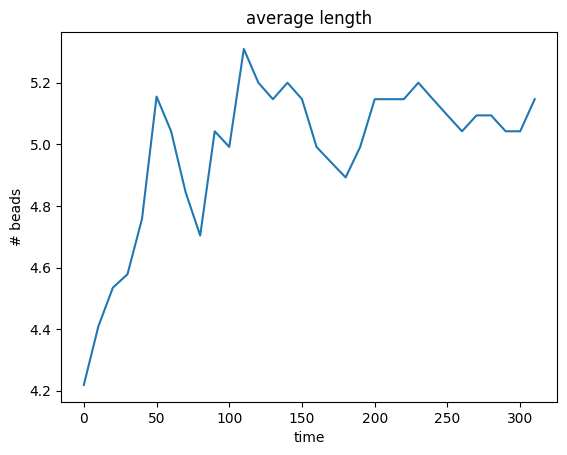

In [13]:
# gather average length of topologies for respective time step
avg_length = []
# for each time step
for topologies in topology_records:
    # gather average polymer length
    avg_length.append(0)
    for top in topologies:
        avg_length[-1] += len(top.edges)
    avg_length[-1] /= len(topologies)
f, ax = plt.subplots(nrows=1, ncols=1)
ax.plot(topology_time, avg_length)
ax.set_title('average length')
ax.set_xlabel('time')
ax.set_ylabel('# beads')
plt.show()

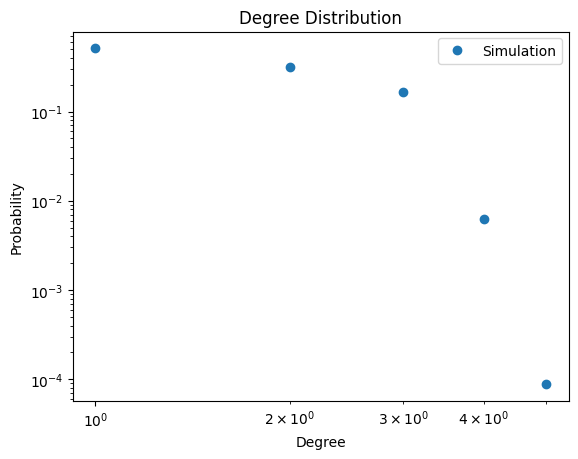

In [14]:

degree_counts = []

# Loop through all recorded topologies
for topologies in topology_records:
    for topology in topologies:
        # Extract connections (edges) from the topology record
        edges = topology.edges  # Returns a list of particle connections
        degrees = Counter()
        for edge in edges:
            # Increment the degree for each particle in the edge
            degrees[edge[0]] += 1
            degrees[edge[1]] += 1
        
        # Collect all degrees from this topology
        degree_counts.extend(degrees.values())

# Count occurrences of each degree
degree_distribution = Counter(degree_counts)
total_nodes = sum(degree_distribution.values())
probabilities = {k: v / total_nodes for k, v in degree_distribution.items()}

# Plot the degree distribution (log-log)
fig, ax = plt.subplots()
ax.loglog(probabilities.keys(), probabilities.values(), 'o', label='Simulation')
ax.set_title('Degree Distribution')
ax.set_xlabel('Degree')
ax.set_ylabel('Probability')
ax.legend()
plt.show()


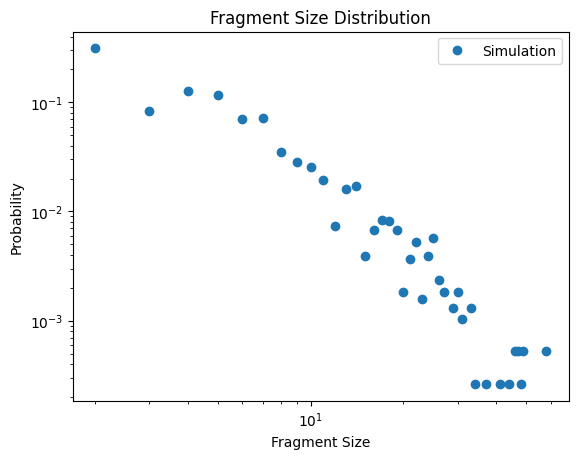

In [15]:
fragment_sizes = []

# Loop through recorded topologies
for topologies in topology_records:
    for topology in topologies:
        # Each topology corresponds to a fragment
        fragment_sizes.append(len(topology.particles))  # Number of particles in the fragment

# Count occurrences of each fragment size
fragment_distribution = Counter(fragment_sizes)
total_fragments = sum(fragment_distribution.values())
fragment_probabilities = {k: v / total_fragments for k, v in fragment_distribution.items()}

# Plot the fragment size distribution (log-log)
fig, ax = plt.subplots()
ax.loglog(fragment_probabilities.keys(), fragment_probabilities.values(), 'o', label='Simulation')
ax.set_title('Fragment Size Distribution')
ax.set_xlabel('Fragment Size')
ax.set_ylabel('Probability')
ax.legend()
plt.show()


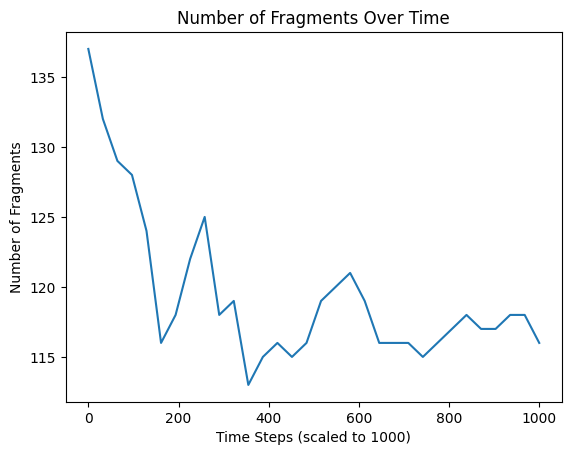

In [16]:

fragment_counts = []
for topologies in topology_records:
    fragment_counts.append(len(topologies))
# Assuming you want to plot every 16th time step and extend the x-axis to 1000
time_steps = np.arange(0, len(fragment_counts) * 16, 16)  # Multiply indices by 16 to reflect the time frame
time_steps_extended = np.linspace(0, 1000, len(fragment_counts))  # Extend x-axis to 1000 evenly spaced steps

# Plot the number of fragments over time
fig, ax = plt.subplots()
ax.plot(time_steps_extended, fragment_counts)
ax.set_title('Number of Fragments Over Time')
ax.set_xlabel('Time Steps (scaled to 1000)')
ax.set_ylabel('Number of Fragments')
plt.show()


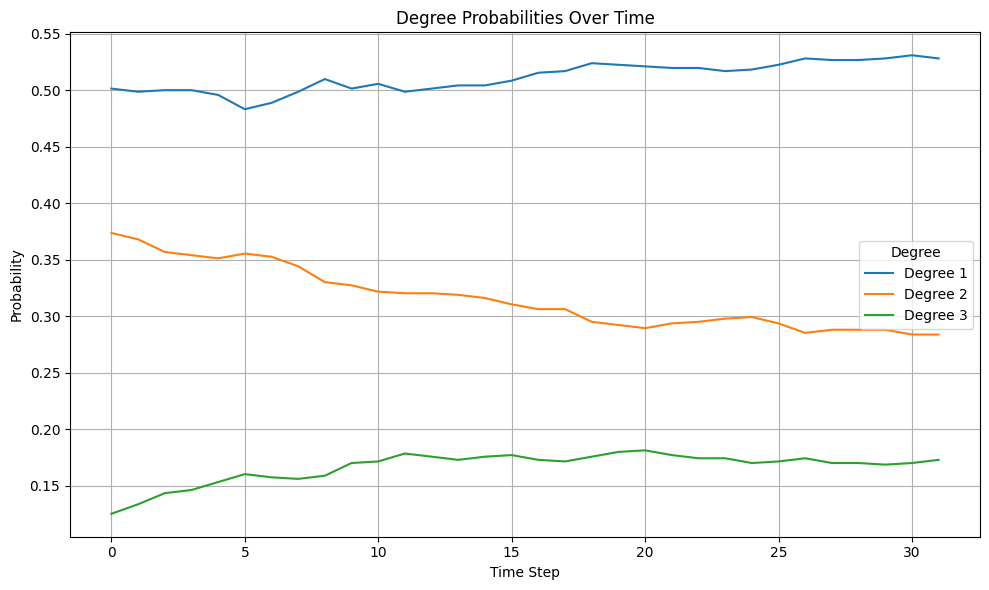

In [17]:
from collections import Counter
import matplotlib.pyplot as plt

# Define degrees to track
tracked_degrees = [1, 2, 3]
tracked_probabilities = {degree: [] for degree in tracked_degrees}
time_steps = []

# Open a log file to write the results
with open("mito_control_image_single_cell_1_degree_probabilities_log.txt", "w") as log_file:
    # Write the header
    log_file.write("TimeStep,Degree1_Prob,Degree2_Prob,Degree3_Prob\n")

    # Loop through all time steps in topology_records
    for t, topologies in enumerate(topology_records):
        degree_counts = []
        for topology in topologies:
            # Extract connections (edges) from the topology record
            edges = topology.edges  # Ensure this attribute exists in your data
            degrees = Counter()
            for edge in edges:
                # Increment the degree for each particle in the edge
                degrees[edge[0]] += 1
                degrees[edge[1]] += 1
            # Collect all degrees from this topology
            degree_counts.extend(degrees.values())
        
        # Count occurrences of each degree
        degree_distribution = Counter(degree_counts)
        total_nodes = sum(degree_distribution.values())
        
        # Prepare a line for logging
        line = [f"{t}"]
        
        # Calculate probabilities for tracked degrees
        for degree in tracked_degrees:
            count = degree_distribution.get(degree, 0)
            probability = count / total_nodes if total_nodes > 0 else 0
            tracked_probabilities[degree].append(probability)
            line.append(f"{probability:.6f}")
        
        # Write the line to the file
        log_file.write(",".join(line) + "\n")
        
        time_steps.append(t)

# Plotting probabilities over time
plt.figure(figsize=(10, 6))
for degree in tracked_degrees:
    plt.plot(time_steps, tracked_probabilities[degree], label=f'Degree {degree}')

plt.xlabel('Time Step')
plt.ylabel('Probability')
plt.title('Degree Probabilities Over Time')
plt.legend(title='Degree')
plt.grid(True)
plt.tight_layout()
plt.show(block=True)


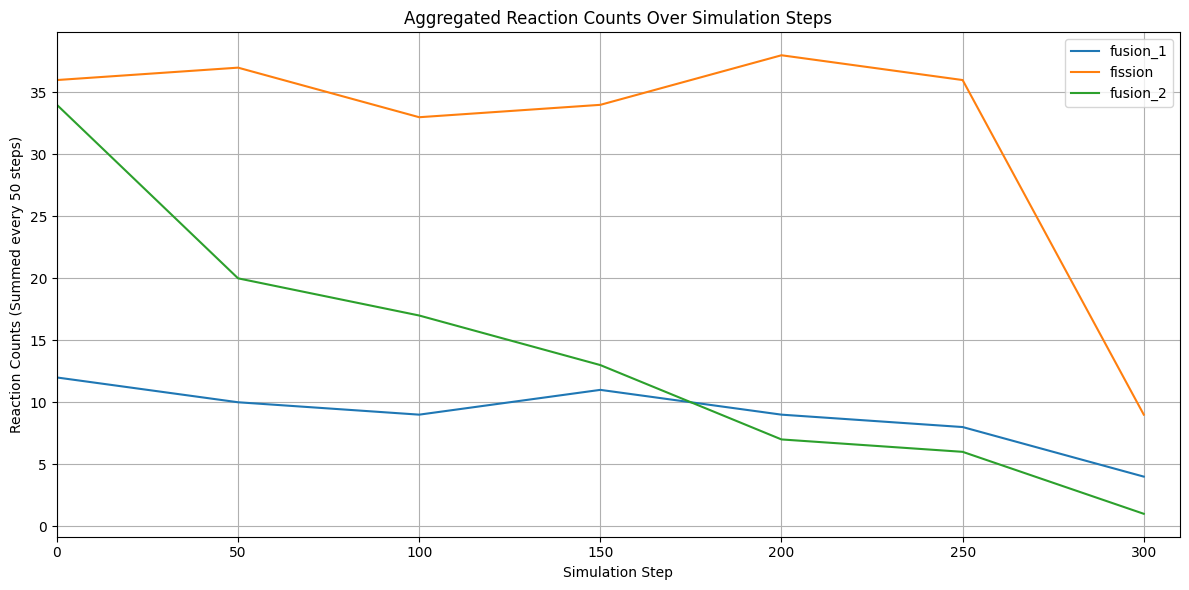

In [18]:
import ast
import matplotlib.pyplot as plt

# Read the Reaction Counts from the Log File
counts = []
with open(COUNT_LOG_FILE, 'r') as log_file:
    for line in log_file:
        count_tuple = ast.literal_eval(line.strip())
        counts.append(count_tuple)

# Aggregate counts every 50 steps
agg_interval = 50
aggregated_counts = []

for i in range(0, len(counts), agg_interval):
    agg_unimol = {}
    agg_bimol = {}
    agg_enzymatic = {}

    for j in range(i, min(i + agg_interval, len(counts))):
        counts_unimol, counts_bimol, counts_enzymatic = counts[j]

        for k, v in counts_unimol.items():
            agg_unimol[k] = agg_unimol.get(k, 0) + v
        for k, v in counts_bimol.items():
            agg_bimol[k] = agg_bimol.get(k, 0) + v
        for k, v in counts_enzymatic.items():
            agg_enzymatic[k] = agg_enzymatic.get(k, 0) + v

    aggregated_counts.append((agg_unimol, agg_bimol, agg_enzymatic))

# Process Aggregated Counts
reaction_names = set()
for count_tuple in aggregated_counts:
    counts_unimol, counts_bimol, counts_enzymatic = count_tuple
    reaction_names.update(counts_unimol.keys())
    reaction_names.update(counts_bimol.keys())
    reaction_names.update(counts_enzymatic.keys())

reaction_counts_over_time = {name: [] for name in reaction_names}
reaction_counts_over_time.pop('fusion_detect', None)  # Optionally exclude

# Fill the data
for count_tuple in aggregated_counts:
    counts_unimol, counts_bimol, counts_enzymatic = count_tuple
    for name in reaction_counts_over_time.keys():
        count = counts_unimol.get(name, 0) + counts_bimol.get(name, 0) + counts_enzymatic.get(name, 0)
        reaction_counts_over_time[name].append(count)

# Generate new time array
time = list(range(0, len(aggregated_counts) * agg_interval, agg_interval))

# Plot the Data
plt.figure(figsize=(12, 6))
for name, count_list in reaction_counts_over_time.items():
    plt.plot(time, count_list, label=name)
plt.xlabel('Simulation Step')
plt.ylabel('Reaction Counts (Summed every 50 steps)')
plt.title('Aggregated Reaction Counts Over Simulation Steps')
plt.legend()
plt.grid(True)
plt.xlim(0, len(counts) - 1)
plt.tight_layout()
plt.show()
